In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('iam-handwritten-word-database'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
images = []
labels = []

RECORDS_COUNT = 30000

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [5]:
with open('iam-handwriting-word-database/iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents] 
lines[-1]

'b06-110-07-03 ok 173 987 2031 8 6 . .'

In [6]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [7]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [8]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'iam-handwriting-word-database/iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
      
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [ ]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))


In [10]:
train_labels[3101]

[70, 67, 56, 65, 55, 60, 65, 58]

In [13]:
train_padded_label[0]

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78])

In [14]:
train_padded_label.shape, valid_padded_label.shape

((18074, 17), (2007, 17))

In [15]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [16]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [17]:
def Model1():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    squeezed = Lambda(lambda x: tf.squeeze(x, 1), output_shape=(31, 512))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs
act_model,outputs,inputs=Model1()

In [18]:
act_model,outputs,inputs=Model1()

In [19]:
act_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31, 79)         │        40,527 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [20]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CTCLossLayer(Layer):
    def call(self, inputs):
        y_pred, labels, input_length, label_length = inputs
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [28]:
# Custom CTC Loss Layer
loss_out = CTCLossLayer(name='ctc')([outputs, the_labels, input_length, label_length])

# Model for training
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)


In [20]:
batch_size = 5
epochs = 25
e = str(epochs)
optimizer_name = 'sgd'

In [21]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.keras".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [22]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.0036 - loss: 15.7362
Epoch 1: val_accuracy improved from -inf to 0.06577, saving model to sgdo-30000r-25e-18074t-2007v.keras


c:\Users\karu8\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


3615/3615 ━━━━━━━━━━━━━━━━━━━━ 743s 204ms/step - accuracy: 0.0036 - loss: 15.7357 - val_accuracy: 0.0658 - val_loss: 11.6656
Epoch 2/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.0673 - loss: 10.8792
Epoch 2: val_accuracy improved from 0.06577 to 0.14300, saving model to sgdo-30000r-25e-18074t-2007v.keras
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 724s 200ms/step - accuracy: 0.0673 - loss: 10.8789 - val_accuracy: 0.1430 - val_loss: 8.4367
Epoch 3/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.1533 - loss: 7.1310
Epoch 3: val_accuracy improved from 0.14300 to 0.25660, saving model to sgdo-30000r-25e-18074t-2007v.keras
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 723s 200ms/step - accuracy: 0.1533 - loss: 7.1308 - val_accuracy: 0.2566 - val_loss: 4.9096
Epoch 4/25
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2684 - loss: 4.4966
Epoch 4: val_accuracy improved from 0.25660 to 0.33184, saving model to sgdo-30000r-25e-18074t-2007v.keras
3615/3615 ━━━━━━━━━━━━━━━━━━━━ 725s 

In [29]:
filepath='sgdo-30000r-25e-18074t-2007v.keras'
# Load the saved best model weights
act_model.load_weights(filepath)

# Predict outputs on validation images
prediction = act_model.predict(valid_images)

# Use CTC decoder (Greedy decoding)
decoded, log_probabilities = tf.keras.backend.ctc_decode(prediction, 
                                                         input_length=np.ones(prediction.shape[0]) * prediction.shape[1], 
                                                         greedy=True)

# Convert decoded predictions to text (you may need to adjust for the actual char_list)
out = []

# Iterate over each decoded sequence (this is a list of lists)
for seq in decoded:
    # Extract and flatten the tensor (if it is multi-dimensional)
    seq = seq.numpy().flatten()  # Flatten to a 1D array if it's multi-dimensional
    out.append([char_list[int(x)] for x in seq if x != -1])  # Ignore -1 (padding or empty tokens)

import Levenshtein as lv

total_jaro = 0

# Calculate Jaro distance for each prediction
for i, x in enumerate(out):
    letters = ''.join(x)  # Join the list of characters into a string
    total_jaro += lv.jaro(letters, valid_original_text[i])

# Print the average Jaro score
print('Jaro :', total_jaro / len(out))



63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step
Jaro : 0.6667041535462589


In [30]:
complete_model_filepath = "complete_model.keras"
act_model.save(complete_model_filepath)
print(f"Model saved to {complete_model_filepath}")

Model saved to complete_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
original_text =  that
predicted text = that

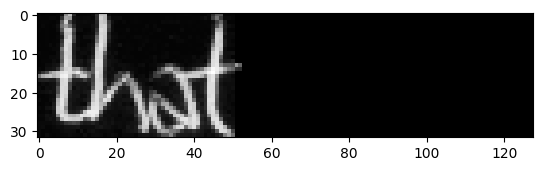



original_text =  want
predicted text = wont

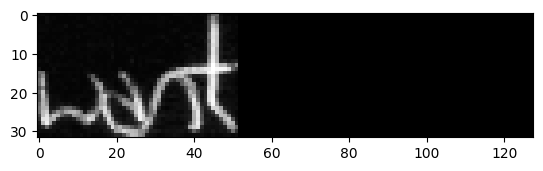



original_text =  in
predicted text = in

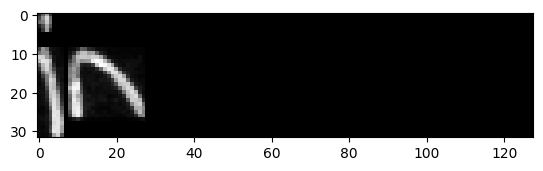



original_text =  ,
predicted text = ,

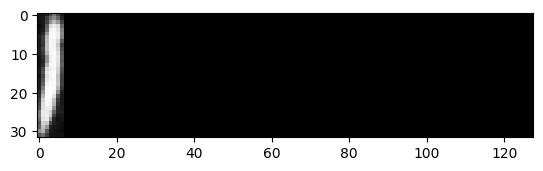



original_text =  .
predicted text = .

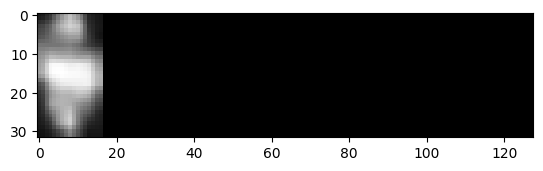

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

i = 2000
j = 2005
prediction = act_model.predict(valid_images[i:j])
 
# Use tf.keras CTC decode
decoded = tf.keras.backend.ctc_decode(
    prediction,
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True
)[0][0]

out = decoded.numpy()

# See the results
for k, x in enumerate(out):
    print("original_text = ", valid_original_text[i])
    print("predicted text = ", end='')
    
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end='')
    
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    
    i += 1
    print('\n')

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess an image from a given path
def load_and_preprocess_image(image_path, target_size=(32, 128)):
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Specify the image path
image_path = 'iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-00-04.png'  # Replace with the path to your image

# Load and preprocess the image
image = load_and_preprocess_image(image_path)

# Assume act_model is your trained model
prediction = act_model.predict(image)

# Use tf.keras CTC decode
decoded = tf.keras.backend.ctc_decode(
    prediction,
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True
)[0][0]

# Convert decoded output to numpy array
out = decoded.numpy()

# Print the results
for x in out:
    print("Predicted text = ", end='')
    for p in x:
        if int(p) != -1:  # Filter out the padding character
            print(char_list[int(p)], end='')
    
    # Display the image
    plt.imshow(image[0].reshape(32, 128), cmap=plt.cm.gray)
    plt.show()

    print('\n')


NameError: name 'act_model' is not defined